# Image Transformation
Generally, There are two types of image transformations
- Change the __RANGE__, or
- Change the __DOMAIN__

---TODO --- @Add reference  @Add visual examples @Inverse warpping @tons of interpolation techniques @pinv, ???
@update numpy tutorial, like np.float([]), np.c_\[x.ravel()\], learning broadcasting 

- splatting
- cylindrical
$$G(x) = h\{F(x)\}$$
$$G(x) = F(l\{x\})$$

## Classification of 2D Transformations

Name | Matrix | #D.O.F | Preserves | Icon
---|---|---|---|---
Translation                          |  $[I | t]$  | 2 | Orientation | &#9633;
Rigid                                |  $[R | t]$ | 3 | Lengths | &#9671;
Similarity (rigid + uniform scaling) |  $[sR | t]$ | 4 | Angles | &#9634;
Affine (linear transform + translating)   |  $[A]$ | 6 | Parallelisms | &#9649;
Projective (Affine + Distortion)     |  $[\tilde{H}]$ | 8  | Lines | &#9186;

##### Extensions on projective transformation
1. __#D.O.G__

Look at a projective matrix
$$
H_p = \begin{bmatrix} a_{11} & a_{12} & t_x\\ a_{21} & a_{22} & t_y \\ v_1 & v_2 & v \end{bmatrix} 
$$
In block Matrix form, it can be written as 
$$
H_p = \begin{bmatrix} A & \mathbf{t}\\ \mathbf{v}^T & v \end{bmatrix} 
$$
where $A$ is a 2D linear transformation, $t$ is a 2D translation vector, $v^T$ is the distortion vector. Given


$$ H_p
\begin{pmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \end{pmatrix} = \begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} \Rightarrow \begin{bmatrix} x'/w' \\ y'/w' \end{bmatrix}
$$

We could find $w' = gx + hy + i$. For converting heterogeneous coordinates to  from homogeneous coordinates, the extra step is divide each element by $w'$, $s. t.$
This explains that why the #D.O.F of projective transform is __8__ and shows that we could change the distortion by altering $v_1$ and $v_2$ given an affine-transformed image.
And just keep in mind that
- $H_p$ can be computed from 4 point correspondence.
- The most fundamental projective invariant is the cross ratio of four collinear points.

### Matrix Composition
$$\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} \quad=\quad \begin{pmatrix}
\begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ v_1 & v_2 & v \end{bmatrix}
\begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \\ 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} cos(\theta) & -sin(\theta) & 0 \\ sin(\theta) & cos(\theta) & 0 \\ 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} s_x & 0 & 0 \\ 0 & s_y & 0 \\ 0 & 0 & 1 \end{bmatrix}
\end{pmatrix} 
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$
<center>
$p'\,\,=\,\,$ projection($v_1, v_2$) $\quad\quad$ translation($t_x, t_y$) $\quad\quad$ rotation($\theta$) $\quad\quad$ scale($s_x, s_y$) $\quad\quad$ $p$
</center>

Note that 
- when multiply with a vector, the order is $H_p ((H_t (H_r (H_s (x)))))$
- translating in 2D means shearing in 3D
- Each invertible linear transformation could be decompose as $PDP^{-1}$ which means $rotating \to scaling \to rotating \,back$

2. __Projective and Perspective__

> The distinctive property of a perspectivity is that the lines joining corresponding points are concurrent. It is made clear by considering the composition of two perspectivities. <br>
The composition of two perspectivities is not in general a perspectivity. However, the composition is a projectivity because a perspectivity is a projectivity, and projectivities form a group (closed), so that the composition of two projectivities is a projectivity.

![perspective-projective](dataset/perspective_projective.png)

Figure above: A line projectivity. Points {$a, b, c$} and {$a', b', c'$} are related to points {A, B, C} by a line-to-line perspectivity. However, points {$a, b, c$} are related to points {$a', b', c'$} by a projectivity, not a perspectivity because lines joining corresponding points are not concurrent. In fact, the pairwise intersections result in three distinct points {$p, q, r$}.

\# Note that a set of lines or curves are said to be concurrent if they all intersect. at the same point, as shown below.

![concurrent-lines](dataset/concurrent-lines.png)

## Forward Warpping and Inverse Warpping

Now we've already find the source image $f(x)$ and an mapping $x' = h(x)$. Next step is to calculate the values of each pixels in the new image $g(x)$. There're two approaches provided: _**Forward Warpping**_ and _**Inverse Warpping**_

Forward warpping is a easier and more intuitive one. However, it suffers from lots of limitations, where inverse wrapping could perform much better.

---
__procedure__ _forwardWrap_$(f, h, out g) $:
1. Compute the location in `destination` $x'$ via $x' = h(x)$ for each pixel in `source`
2. Sample and assign f(x) to x'

---
__procedure__ _inverseWrap_$(f, h, out g) $:

1. Compute the location in `source` $x$ via $x = h^{-1}(x')$ for each pixel in `destination`
2. Sample and assign f(x) to  x'

---

Let's implement them using opencv

In [2]:
import cv2

In [3]:
from matplotlib import pyplot as plt

In [4]:
import numpy as np

In [5]:
img = cv2.imread('dataset/lena_std.tif')

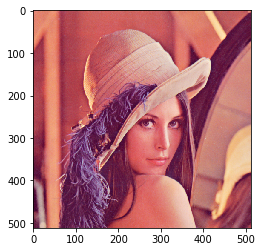

In [6]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.axis("off")
plt.imshow(rgb_img)

In [7]:
def forward_translate(f, h):
#    It will map x' to the nearst pixel
#    Args:
#        f (ndarray): An image
#        h (ndarray): A 3 * 3 matrix that present a 2D transformation
#
#    Returns:
#        ndarray: The result of forward translation 

    if f is None or h is None:
        raise Exception('Null value is not supported')
        
    if type(f).__module__ != np.__name__:
        raise Exception('The image must be a ndarray')
        
    if type(h).__module__ != np.__name__:
        raise Exception('The transformation matrix must be a ndarray')
    if f.ndim != 3:
        raise Exception('The ndim of the input image must be 3, but yours is %d' % f.ndim)
  
    py, px = np.mgrid[0:f.shape[0]:1, 0:f.shape[1]:1]
    points = np.c_[px.ravel(), py.ravel(), np.ones(px.size, dtype = int)]
    points = points @ h.T
    #print(points)
#
#points: 
#        ------>
#        ------>
#        ------>
    x, y, z = np.hsplit(points, 3)
    x = x // z
    y = y // z
    x_sq = x.reshape(px.shape)
    y_sq = y.reshape(py.shape)
    
    left = np.floor(np.min(x_sq)).astype(int)
    x_sq = x_sq - left if left < 0 else x_sq
    
    top = np.floor(np.min(y_sq)).astype(int)
    y_sq = y_sq - top if top < 0 else y_sq
    
    height = np.ceil(np.max(y_sq)).astype(int)
      
    width = np.ceil(np.max(x_sq)).astype(int)
    mappings = np.asarray((x_sq, y_sq)).astype(int)
    out = np.zeros((height + 1, width + 1, 3), dtype = np.uint8)
    for y in range(f.shape[0]):
        for x in range(f.shape[1]):
            out[mappings[1, y, x],  mappings[0, y, x], :] = f[y, x, :]
    return out

##### Note that in image representation, a LEFT-HAND-AXIS is adapted!!! so the direction of rotation is opposite

In [8]:
def translation_matrix(x, y):
#    Args:
#        x(int): the offset in x-coor
#        y(int): the offset in y-coor
#    Returns:
#        H_t(ndarray): the desired translation matrix
    return np.array([[1, 0, x], [0, 1, y], [0, 0, 1]])

In [9]:
def rotation_matrix(theta):
#    Args:
#        x(int): the offset in x-coor
#    Returns:
#        H_t(ndarray): the desired translation matrix
    theta = np.deg2rad(theta)
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

In [10]:
def scale_matrix(scalar):
    return np.array([[scalar, 0, 0], [0, scalar, 0], [0, 0, 1]])

In [11]:
def aspect_matrix(aspect_ratio):
    return np.array([[1, 0, 0], [0, 1 / aspect_ratio, 0], [0, 0, 1]])

In [12]:
# as mentioned before, shearing is actualling a 'rotate' --> scale --> 'rotate back'
def shear_matrix(x, y):
    return np.array([[1, x, 0], [y, 1, 0], [0, 0, 1]])

In [13]:
def projective_matrix(v1, v2):
    return np.array([[1, 0, 0], [0, 1, 0], [v1, v2, 1]])

Now we can construct our own transformation.
The parameters for projection are usually small

True

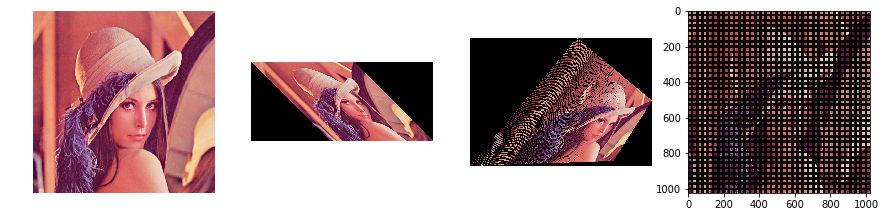

In [14]:
matrix1 = np.linalg.multi_dot((shear_matrix(1, 0), aspect_matrix(1.3)))
out1 = forward_translate(img, matrix1)
matrix2 = np.linalg.multi_dot((projective_matrix(0.001, 0.0005), rotation_matrix(40), aspect_matrix(1.5), scale_matrix(2)))
out2 = forward_translate(img, matrix2)
matrix3 = scale_matrix(2)
out3 = forward_translate(img, matrix3)
# 
f, axarr = plt.subplots(1, 4, figsize = (15, 15))
axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[0].axis("off")
axarr[1].imshow(cv2.cvtColor(out1, cv2.COLOR_BGR2RGB))
axarr[1].axis("off")
axarr[2].imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))
axarr[2].axis("off")
axarr[3].imshow(cv2.cvtColor(out3, cv2.COLOR_BGR2RGB))

cv2.imwrite("dataset/projection.jpg", out2)
cv2.imwrite("dataset/scale.jpg", out3)

Another interesting finding is the sampling affect. Anyway, reading from output file, we find it works. If we view the scale.jpg, it will be varied in different size... 

Projection | Scale
--- | ---
<img src="dataset/projection.jpg" alt="Projection" style="width: 300px;"/> | <img src="dataset/scale.jpg" alt="Scale" style="width: 300px;"/>

The result complains about the bad performance. After transformation, $x'$ is usually a non-integer value, which is not well defined. In this case, we may assign it to the nearsest pixel of $x'$, but it suffers from cracks and holes. Another technique is called __SPLATTING__ means that for each value that desired to put into $x'$, instead, we distribute it among its four neighbors in a weighted (bilinear) function; we keep track of the weights per pixel and normalizing them at the end. It is sometimes used for volume renderingsuffers from both moderate amounts of aliasing and a fair amount of blur (loss of high-resolution detail).

\# Inverse Wraping may be implemented in the future

## Geometric Transformation in OpenCV
For common geometric transformations, opencv provides three apis: _cv.resize_, _cv.warpAffine_ and _cv.warpPerspective_. And later it will show that the existing apis perform MUCH BETTER than us..

#### Scaling

`dst = cv.resize(	src, dsize[, dst[, fx[, fy[, interpolation]]]]`	

where dsize means the size of destination, alternatively we could input the fx, fy, which means the scale factor.
     
To shrink an image, it will generally look best with `INTER_AREA` interpolation, whereas to enlarge an image, it will generally look best with `INTER_CUBIC` (slow) or `INTER_LINEAR` (faster but still looks OK).

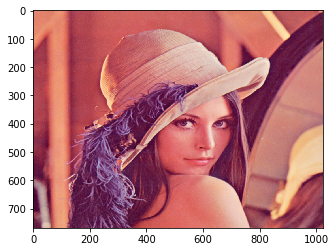

In [15]:
scaled = cv2.resize(img, None, fx = 2, fy = 1.5, interpolation = cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB))

#### Affine
Linear transformation is a special case of affine, so for all transformation without projection, we could use this. But before finding the fantastic result, we need to construct the matrix first. The approach varies.

Rotation matrix with optional uniform scaling
- `retval = cv.getRotationMatrix2D( center, angle, scale ) ` 

Affine transform can be calculated from three pairs of corresponding points (recall the #D.O.F)
- `retval = cv.getAffineTransform( src, dst )`


In [16]:
M1 = np.float32([[1,0,100],[0,1,50]]) # defind by our self as long as its shape is (2, 3)
M2 = cv2.getRotationMatrix2D(((img.shape[1]-1)/2.0,(img.shape[0]-1)/2.0), 45 ,1)
M3 = cv2.getAffineTransform(np.float32([[50,50],[200,50],[50,200]]), np.float32([[10,100],[200,50],[100,250]]))

The shape of affine transform should be Then put it to the api.
- `dst = cv.warpAffine( src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]] )`


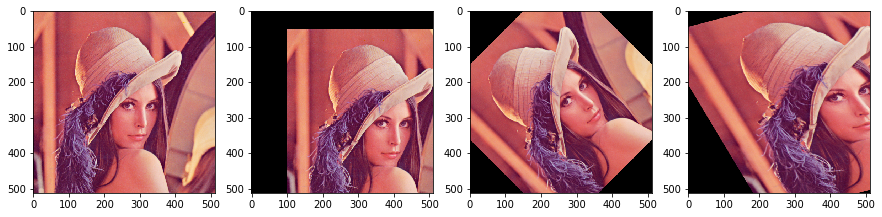

In [17]:
out11 = cv2.warpAffine(img, M1, img.shape[:2])
out22 = cv2.warpAffine(img, M2, img.shape[:2])
out33 = cv2.warpAffine(img, M3, img.shape[:2])

outs = [img, out11, out22, out33]

f, axarr = plt.subplots(1, 4, figsize = (15, 15))

for i in range(4):
    axarr[i].imshow(cv2.cvtColor(outs[i], cv2.COLOR_BGR2RGB))

#### Perspective
Again we may build perspective matrix by ourself, but it's safer to use the api. Its size is $3 \times 3$

- `cv2.getPerspectiveTransform( src, dst[, solveMethod] )`

In [29]:
pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
M4 = cv2.getPerspectiveTransform(pts1,pts2)
M5 = np.linalg.multi_dot((projective_matrix(-0.001, 0.00), translation_matrix(150, 0), rotation_matrix(35), aspect_matrix(1.3)))

Finally 
- `dst = cv.warpPerspective( src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]] )`

(-0.5, 511.5, 511.5, -0.5)

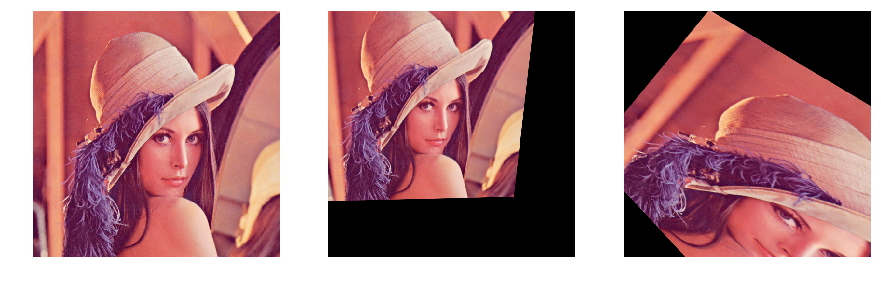

In [30]:
out4 = cv2.warpPerspective(img, M4, (img.shape[:2]))
out5 = cv2.warpPerspective(img, M5, (img.shape[:2]))

f, axarr = plt.subplots(1, 3, figsize = (15, 15))
axarr[1].imshow(cv2.cvtColor(out4, cv2.COLOR_BGR2RGB))
axarr[1].axis("off")

axarr[2].imshow(cv2.cvtColor(out5, cv2.COLOR_BGR2RGB))
axarr[2].axis("off")

axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[0].axis("off")

The last section is to implement cor
getAffineTransform
getPerspectiveTransform

In [83]:
pst1, pst2 = np.float32([[50,50],[200,50],[50,200]]), np.float32([[10,100],[200,50],[100,250]])
def getAffineTransformation(pst1, pst2):
    ones = np.ones((3,1))
    ps1 = np.hstack((pst1, ones)).T
    return pst2.T @ np.linalg.pinv(ps1)
    
print("ourself\n", getAffineTransformation(pst1, pst2))
print("cv2\n", cv2.getAffineTransform(pst1, pst2))

ourself
 [[  1.26666667   0.6        -83.33333333]
 [ -0.33333333   1.          66.66666667]]
cv2
 [[  1.26666667   0.6        -83.33333333]
 [ -0.33333333   1.          66.66666667]]


In [93]:
pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
def getPerspectiveTransform(pst1, pst2):
    ps1 = np.hstack((pst1, np.ones((4,1)))).T
    ps2 = np.hstack((pst2, np.ones((4,1)))).T
    return ps2 @ np.linalg.pinv(ps1)
print("ourself\n", getPerspectiveTransform(pts1, pts2))
print("cv2\n", cv2.getPerspectiveTransform(pts1, pts2))

[[ 56.  65.   1.]
 [368.  52.   1.]
 [ 28. 387.   1.]
 [389. 390.   1.]]
ourself
 [[ 8.86913327e-01  7.73272122e-03 -3.82017902e+01]
 [ 1.18596769e-02  9.08635985e-01 -5.55736397e+01]
 [ 2.60208521e-18  1.30104261e-18  1.00000000e+00]]
cv2
 [[ 1.05587376e+00  9.18151097e-02 -6.50969128e+01]
 [ 4.69010049e-02  1.12562412e+00 -7.57920240e+01]
 [ 1.83251448e-04  5.13337001e-04  1.00000000e+00]]
